In [1]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun    
import numpy as np

In [2]:
# moment-based inference
def MomentInference(vals, export_moments=False):
    # code from Anton Larsson's R implementation
    from scipy import stats # needs imports inside function when run in ipyparallel
    import numpy as np
    m1 = float(np.mean(vals))
    m2 = float(sum(vals*(vals - 1))/len(vals))
    m3 = float(sum(vals*(vals - 1)*(vals - 2))/len(vals))
    
    # sanity check on input (e.g. need at least on expression level)
    if sum(vals) == 0: return np.nan
    if m1 == 0: return np.nan
    if m2 == 0: return np.nan
    
    r1=m1
    r2=m2/m1
    r3=m3/m2
    
    if (r1*r2-2*r1*r3 + r2*r3) == 0: return np.nan
    if ((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3)) == 0: return np.nan
    if (r1 - 2*r2 + r3) == 0: return np.nan
        
    lambda_est = (2*r1*(r3-r2))/(r1*r2-2*r1*r3 + r2*r3)
    mu_est = (2*(r3-r2)*(r1-r3)*(r2-r1))/((r1*r2 - 2*r1*r3 + r2*r3)*(r1-2*r2+r3))
    v_est = (2*r1*r3 - r1*r2 - r2*r3)/(r1 - 2*r2 + r3)
    
    if export_moments:
        return np.array([lambda_est, mu_est, v_est, r1, r2, r3])
    
    return np.array([lambda_est, mu_est, v_est])
def MaximumLikelihood(vals, export_asymp_ci = False, fix = 0, export_fun = False):
    from scipy.interpolate import interp1d
    from scipy.optimize import minimize
    from scipy import special
    from scipy.stats import poisson,norm
    from scipy.special import j_roots
    from scipy.special import beta as beta_fun    
    import numpy as np
    if len(vals) == 0:
        return np.array([np.nan, np.nan, np.nan])
    def dBP(at, alpha, bet, lam):
        at.shape = (len(at), 1)
        np.repeat(at, 50, axis = 1)
        def fun(at, m):
            if(max(m) < 1e6):
                return(poisson.pmf(at,m))
            else:
                return(norm.pdf(at,loc=m,scale=sqrt(m)))
        
        x,w = j_roots(50,alpha = bet - 1, beta = alpha - 1)
        gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
        prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
        return(prob)
    def LogLikelihood(x, vals):
        kon = x[0]
        koff = x[1]
        ksyn = x[2]
        return(-np.sum(np.log( dBP(vals,kon,koff,ksyn) + 1e-10) ) )
    x0 = MomentInference(vals)
    if np.isnan(x0).any():
        x0 = np.array([10,10,10])
    bnds = ((1e-3,1e3),(1e-3,1e3), (1, 1e10))
    vals_ = np.copy(vals) # Otherwise the structure is violated.
    try:
        ll = minimize(LogLikelihood, x0, args = (vals_), method='L-BFGS-B', bounds = bnds)
    except:
        if export_fun:
            return np.array([np.nan,np.nan,np.nan]), np.nan
        return np.array([np.nan,np.nan,np.nan])
    #se = ll.hess_inv.todense().diagonal()
    if export_fun:
        return ll.x, ll.fun
    estim = ll.x
    return estim
def ProfileLikelihood3(vals, alph = 0.05):
    from scipy.interpolate import interp1d
    from scipy.optimize import minimize, fsolve
    from scipy import special
    from scipy.stats import poisson,norm, chi2
    from scipy.special import j_roots
    from scipy.special import beta as beta_fun
    import numpy as np
    def dBP(at, alpha, bet, lam):
        at.shape = (len(at), 1)
        np.repeat(at, 50, axis = 1)
        def fun(at, m):
            if(max(m) < 1e6):
                return(poisson.pmf(at,m))
            else:
                return(norm.pdf(at,loc=m,scale=sqrt(m)))
        x,w = j_roots(50,alpha = bet - 1, beta = alpha - 1)
        gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
        prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
        return(prob)
    def ll_kon(x, l, obs):
        mu = x[0]
        v = x[1]
        return(-np.sum(np.log(dBP(obs,l,mu,v) + 1e-10)))
    def ll_burst_size(x, burst_size, obs):
        l = x[0]
        v = x[1]
        mu = v/burst_size
        return(-np.sum(np.log(dBP(obs,l,mu,v) + 1e-10)))
    def minll_kon(x, kon, obs):
        bnds = ((1e-3, 1e3), (1,1e10))
        res = minimize(ll_kon, x, args = (kon,obs), method='L-BFGS-B', bounds = bnds)
        ll = res.fun
        x0 = res.x
        return ll, x0
    def minll_burst_size(x, burst_size, obs):
        bnds = ((1e-3, 1e3), (1,1e6))
        res = minimize(ll_burst_size, x, args = (burst_size,obs), method='L-BFGS-B', bounds = bnds)
        ll = res.fun
        x0 = res.x
        return ll, x0
    def get_h(param):
        x = np.log10(param)
        h = 10**(x-2)
        return(h)
    
    def kon_ll(vals,start_estim):
        cutoff = chi2.ppf(1-alph, 1)/2
        x0 = [start_estim[1], start_estim[2]]
        bnds = ((1e-3, 1e3), (1,1e10))
        N = 100
        start = start_estim[0]
        res = minimize(ll_kon, x0, args = (start,vals), method='L-BFGS-B', bounds = bnds)
        h = get_h(start)
        h = 5*h
        ll_p = res.fun
        ll_l = np.zeros(N)
        kon_l = np.array([])
        try:
            for i in range(N):
                kon = start - h*i
                if kon <= 0:
                    break
                kon_l = np.append(kon_l, kon)
                try:
                    res = minimize(ll_kon, res.x, args = (kon,vals), method='L-BFGS-B', bounds = bnds)
                except ValueError:
                    break
                ll_l[i] = res.fun
                if (2*(ll_l[i] - min(ll_l[ll_l > 0])) > cutoff + 0.5) and (ll_l[i] > ll_l[i-1]):
                    break
        except ValueError:
            return np.array([minimum,np.nan,np.nan]), np.nan
        
        ll_l = ll_l[:i+1]
        ll_l = ll_l[::-1]
        kon_l = kon_l[::-1] 
        res = minimize(ll_kon, x0, args = (start,vals), method='L-BFGS-B', bounds = bnds)
        ll_u = np.zeros(N)
        kon_u = np.array([])
        try:
            for j in range(N):
                kon = start + h*j
                kon_u = np.append(kon_u, kon)
                try:
                    res = minimize(ll_kon, res.x, args = (kon,vals), method='L-BFGS-B', bounds = bnds)
                except ValueError:
                    break
                ll_u[j] = res.fun
                if (2*(ll_u[j] - min(ll_u[ll_u > 0])) > cutoff + 0.5) and (ll_u[j] > ll_u[j-1]):
                    break
        except ValueError:
            return np.array([minimum,np.nan,np.nan]), np.nan
        
        ll_u = ll_u[:j+1]
        
        ll = np.concatenate((ll_l[:-1],np.array([ll_p]),ll_u[1:]))
        kon_indexed = np.concatenate((kon_l[:-1],np.array([start]),kon_u[1:])).squeeze()
        
        ll_ratio = 2*(ll - min(ll)).squeeze()
        
        minimum_idx = np.argmin(ll_ratio)
        
        ll_right_side = ll_ratio[minimum_idx:]
        ll_left_side = ll_ratio[:minimum_idx]
        
        minimum = kon_indexed[minimum_idx]
        kon_right_side = kon_indexed[minimum_idx:]
        kon_left_side = kon_indexed[:minimum_idx]
        try:
            f_1 = interp1d(ll_left_side,kon_left_side, kind='cubic')
            f_2 = interp1d(ll_right_side,kon_right_side , kind='cubic')
            res = np.array([minimum, f_1(cutoff), f_2(cutoff)])
            return res, kon_indexed, ll_ratio
        except (ValueError,np.linalg.linalg.LinAlgError, TypeError):
            return np.array([minimum,np.nan,np.nan]), kon_indexed, ll_ratio

    def burst_size_ll(vals, start_estim):
        cutoff = chi2.ppf(1-alph, 1)/2
        x0 = [start_estim[0], start_estim[2]]
        bnds = ((1e-3, 1e3), (1,1e10))
        N = 100
        start = start_estim[2]/start_estim[1]
        res = minimize(ll_burst_size, x0, args = (start,vals), method='L-BFGS-B', bounds = bnds)
        h = get_h(start)
        h = 3*h
        ll_p = res.fun
        ll_l = np.zeros(N)
        burst_size_l = np.array([])
        try:
            for i in range(N):
                burst_size = start - h*i
                if burst_size <= 0:
                    break
                burst_size_l = np.append(burst_size_l, burst_size)
                try:
                    res = minimize(ll_burst_size, res.x, args = (burst_size,vals), method='L-BFGS-B', bounds = bnds)
                except ValueError:
                    break
                ll_l[i] = res.fun
                if (2*(ll_l[i] - min(ll_l[ll_l > 0])) > cutoff + 0.5) and (ll_l[i] > ll_l[i-1]):
                    break
        except ValueError:
            return np.array([minimum,np.nan,np.nan]), np.nan
        ll_l = ll_l[:i+1]
        ll_l = ll_l[::-1]
        burst_size_l = burst_size_l[::-1] 
        res = minimize(ll_burst_size, x0, args = (start,vals), method='L-BFGS-B', bounds = bnds)
        ll_u = np.zeros(N)
        burst_size_u = np.array([])
        try:
            for j in range(N):
                burst_size = start + h*j
                burst_size_u = np.append(burst_size_u, burst_size)
                try:
                    res = minimize(ll_burst_size, res.x, args = (burst_size,vals), method='L-BFGS-B', bounds = bnds)
                except ValueError:
                    break
                ll_u[j] = res.fun
                if (2*(ll_u[j] - min(ll_u[ll_u > 0])) > cutoff + 0.5) and (ll_u[j] > ll_u[j-1]):
                    break
        except ValueError:
            return np.array([minimum,np.nan,np.nan]), np.nan
        
        ll_u = ll_u[:j+1]
        
        ll = np.concatenate((ll_l[:-1],np.array([ll_p]),ll_u[1:]))
        burst_size_indexed = np.concatenate((burst_size_l[:-1],np.array([start]),burst_size_u[1:])).squeeze()
        
        ll_ratio = 2*(ll - min(ll)).squeeze()
        
        minimum_idx = np.argmin(ll_ratio)
        
        ll_right_side = ll_ratio[minimum_idx:]
        ll_left_side = ll_ratio[:minimum_idx]
        
        minimum = burst_size_indexed[minimum_idx]
        burst_size_right_side = burst_size_indexed[minimum_idx:]
        burst_size_left_side = burst_size_indexed[:minimum_idx]
        try:
            f_1 = interp1d(ll_left_side,burst_size_left_side, kind='linear')
            f_2 = interp1d(ll_right_side,burst_size_right_side , kind='linear')
            res = np.array([minimum, f_1(cutoff), f_2(cutoff)])
            return res, burst_size_indexed, ll_ratio
        except (ValueError,np.linalg.linalg.LinAlgError, TypeError):
            return np.array([minimum,np.nan,np.nan]), burst_size_indexed, ll_ratio
    vals_ = np.copy(vals)
    start_estim = MaximumLikelihood(vals_)
    try:
        res_kon, kon_idx, kon_ll_ratio = kon_ll(vals_, start_estim)
        res_burst_size, bs_idx, bs_ll_ratio = burst_size_ll(vals_,start_estim)
    except BaseException:
        return np.array([np.nan,np.nan,np.nan]), np.nan, np.array([np.nan,np.nan,np.nan]), np.nan
    return res_kon, kon_idx, kon_ll_ratio, res_burst_size, bs_idx, bs_ll_ratio

In [3]:
from numpy.random import beta, poisson
def sim_beta_poisson(kon,koff,ksyn=100, size=100):
    "Generate simulated single-cell RNA-seq data according to the two-state model and with parameters kon, koff, ksyn"
    v = beta(kon, koff, size)
    return poisson(v*ksyn)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.random.seed(12039213)

In [6]:
X = sim_beta_poisson(0.5,0.5,20, 200)

In [7]:
Y = ProfileLikelihood3(X)

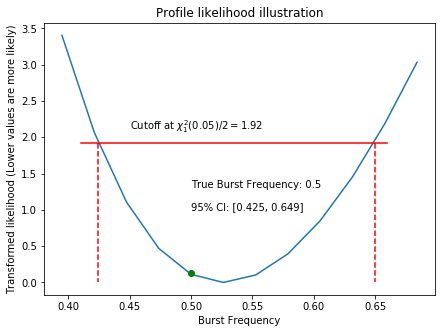

In [11]:
plt.figure(figsize=(7,5))
plt.plot(Y[1], Y[2])
plt.plot([0.41, 0.66], [1.92, 1.92], '-', c='r')
plt.plot([0.424, 0.424], [1.92,0], '--', c='r')
plt.plot([0.65, 0.65], [1.92,0], '--', c='r')
plt.plot([0.5],[0.125], 'o', c = 'g')
plt.title('Profile likelihood illustration')
plt.xlabel(r'Burst Frequency')
plt.ylabel('Transformed likelihood (Lower values are more likely)')
plt.text(0.45, 2.1, r'Cutoff at $\chi_1^2(0.05)/2 = 1.92$')
plt.text(0.5, 1.3, r'True Burst Frequency: 0.5')
plt.text(.5,1,r'95%% CI: [%s, %s]' % (np.round(Y[0][1],3), np.round(Y[0][2],3)))
plt.savefig('figures/ExtDataFig1b.pdf', dpi=100)
plt.show()